In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
%matplotlib inline

In [21]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [22]:
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('Y_train Shape: {}'.format(y_train.shape))
print('Y_test Shape: {}'.format(y_test.shape))

X_train Shape: (50000, 32, 32, 3)
X_test Shape: (10000, 32, 32, 3)
Y_train Shape: (50000, 1)
Y_test Shape: (10000, 1)


In [23]:
X_train = X_train/255 #normalizing pixel values to be between 0 and 1 rather than 0-255
X_test = X_test/255

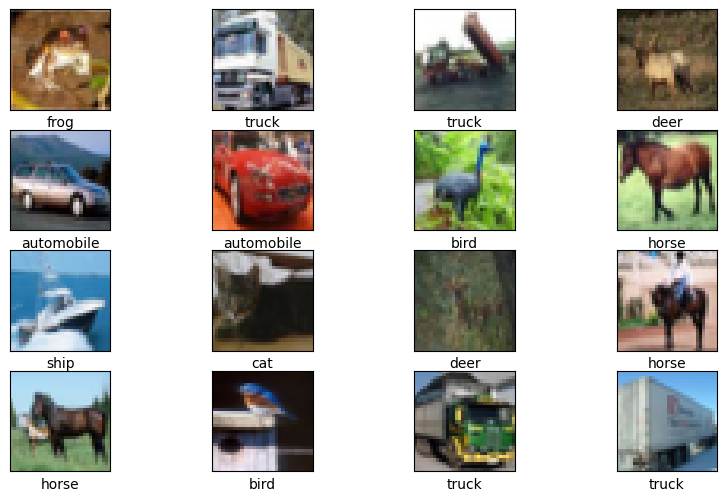

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [24]:
y_train = to_categorical(y_train, 10) #onehot encode labels
y_test = to_categorical(y_test, 10)

In [ ]:
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('Y_train Shape: {}'.format(y_train.shape))
print('Y_test Shape: {}'.format(y_test.shape))

X_train Shape: (50000, 32, 32, 3)
X_test Shape: (10000, 32, 32, 3)
Y_train Shape: (50000, 10)
Y_test Shape: (10000, 10)


In [25]:
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state=7777) #create val set for hyperparam tuning


In [26]:
!pip install scikeras

In [27]:
!pip install keras-tuner

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV #:( sucks to suck, won't use
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
from kerastuner.tuners import Hyperband
from tensorflow.keras.optimizers import Adam, SGD
from kerastuner import HyperParameters
from keras_tuner import HyperParameters


In [29]:
from tensorflow.keras import regularizers

In [ ]:
#Since the project explicitly states to do hyperparam search using my validation set, I couldn't use gridsearhch easily so i used hyperband
def build_hypermodel(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('n_filters', min_value=32, max_value=64, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu', input_shape=(32, 32, 3))) #input shape is 32,32,3
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=hp.Int('n_filters', min_value=64, max_value=128, step=64),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.5, 0.25])))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
tuner = Hyperband(
    build_hypermodel,
    objective='val_accuracy',
    max_epochs=10, # for time purposes
    directory='hyperband',
    project_name='cifar10'
)

I'm using Hyperband even though I have a small space for hyperparameters and it can miss the BEST configuration because it doesn't evaluate every option. I'm doing that I can incorporate my cal set more easily than GridSearchCV and it is more efficient than GridSearch and since this dataset is big, I don't want to wait forever. ChatGPT estimated the times of both libraries with my specifications and GridSearch took twice as long in its estimations.

In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Trial 8 Complete [00h 04m 25s]
val_accuracy: 0.5521000027656555

Best val_accuracy So Far: 0.6200000047683716
Total elapsed time: 00h 23m 54s


To study "the effects of various weight initialization schemes, optimizers, learning rate schedules and regularization methods (e.g.
augmentation, weight decay, etc) on performance", I will change some aspects of my model but I decided to do that after hyperparameter tuning because it wouldn't be computationally sensible to do so together and it would take forever. So I will explore those on my baseline model.

The best number of filters in the first Conv2D layer: 64
The best kernel size in Conv2D layers: 3
The best dropout rate: 0.25
Epoch 1/10
1250/1250 [==============================] - 93s 74ms/step - loss: 1.5491 - accuracy: 0.4383 - val_loss: 1.2490 - val_accuracy: 0.5513
Epoch 2/10
1250/1250 [==============================] - 90s 72ms/step - loss: 1.2270 - accuracy: 0.5666 - val_loss: 1.1182 - val_accuracy: 0.6049
Epoch 3/10
1250/1250 [==============================] - 95s 76ms/step - loss: 1.0922 - accuracy: 0.6162 - val_loss: 1.0563 - val_accuracy: 0.6304
Epoch 4/10
1250/1250 [==============================] - 91s 73ms/step - loss: 1.0081 - accuracy: 0.6441 - val_loss: 0.9838 - val_accuracy: 0.6580
Epoch 5/10
1250/1250 [==============================] - 100s 80ms/step - loss: 0.9521 - accuracy: 0.6674 - val_loss: 0.9562 - val_accuracy: 0.6644
Epoch 6/10
1250/1250 [==============================] - 97s 78ms/step - loss: 0.8965 - accuracy: 0.6873 - val_loss: 0.9126 - val_accuracy: 0.67

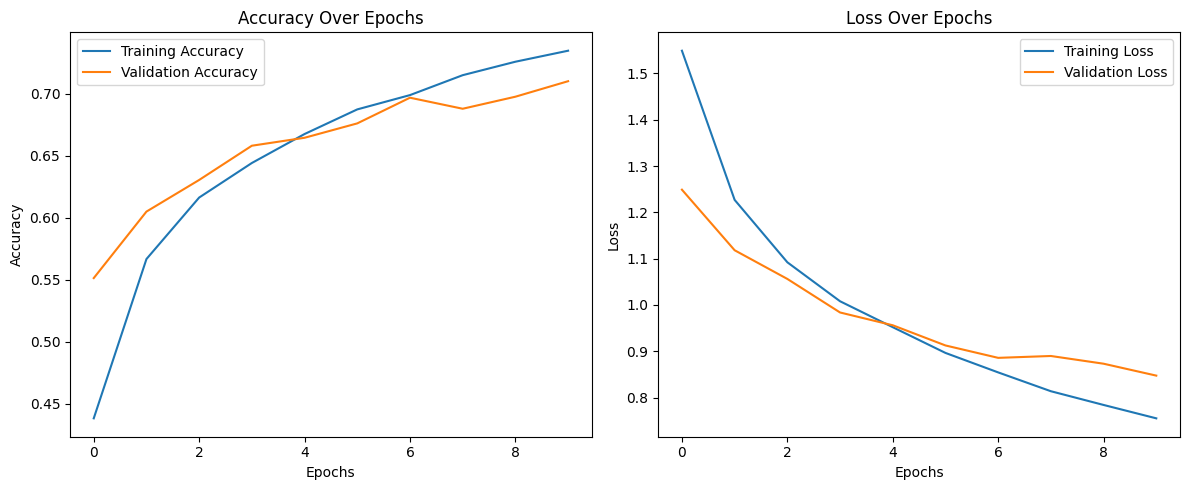

313/313 [==============================] - 5s 17ms/step - loss: 0.8577 - accuracy: 0.7005
Test loss: 0.8576585650444031
Test accuracy: 0.7005000114440918


In [ ]:

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The best number of filters in the first Conv2D layer: {best_hps.get('n_filters')}")
print(f"The best kernel size in Conv2D layers: {best_hps.get('kernel_size')}")
print(f"The best dropout rate: {best_hps.get('dropout_rate')}")


best_model = build_hypermodel(best_hps)


history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


In [30]:
from tensorflow.keras import models
from tensorflow.keras import layers


In [31]:

def build_model(hp):
    model = Sequential()
    n_filters = 64
    dropout_rate = 0.25
    kernel_size = 3

    weight_init_choices = {
        'he_normal': tf.keras.initializers.HeNormal(),
        'glorot_uniform': tf.keras.initializers.GlorotUniform(),
        'random_normal': tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05),
    }
    weight_initializer = hp.Choice('weight_initializer', values=list(weight_init_choices.keys()), default='glorot_uniform')

    model = models.Sequential()
    model.add(layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer=weight_init_choices[weight_initializer]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters=n_filters*2, kernel_size=(kernel_size, kernel_size), padding='same', activation='relu', kernel_initializer=weight_init_choices[weight_initializer]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu', kernel_initializer=weight_init_choices[weight_initializer]))
    l2_value = hp.Float('l2_regularization', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.add(layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(l2_value)))

    initial_learning_rate = hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    hp_learning_rate_schedule = hp.Choice('learning_rate_schedule', values=['constant', 'exponential_decay', 'step_decay'])

    if hp_learning_rate_schedule == 'constant':
        lr_schedule = initial_learning_rate
    elif hp_learning_rate_schedule == 'exponential_decay':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
    elif hp_learning_rate_schedule == 'step_decay':
        def step_decay(epoch):
            drop_rate = 0.5
            epochs_drop = 10.0
            return initial_learning_rate * (drop_rate ** np.floor((1+epoch)/epochs_drop))
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(step_decay)

    hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])

    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model



In [32]:
tuner2 = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='cifar10_hyperparam_tuning',
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True
)


tuner2.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

best_model = tuner2.get_best_models(num_models=1)[0]

best_model.summary()


Trial 23 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.7477999925613403
Total elapsed time: 04h 09m 51s
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
          

In [36]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/10
1250/1250 [==============================] - 252s 200ms/step - loss: 1.4231 - accuracy: 0.4994 - val_loss: 1.1305 - val_accuracy: 0.6165
Epoch 2/10
1250/1250 [==============================] - 278s 222ms/step - loss: 1.0536 - accuracy: 0.6350 - val_loss: 1.0176 - val_accuracy: 0.6556
Epoch 3/10
1250/1250 [==============================] - 280s 224ms/step - loss: 0.9075 - accuracy: 0.6887 - val_loss: 0.9171 - val_accuracy: 0.6853
Epoch 4/10
1250/1250 [==============================] - 276s 221ms/step - loss: 0.8027 - accuracy: 0.7297 - val_loss: 0.8592 - val_accuracy: 0.7052
Epoch 5/10
1250/1250 [==============================] - 283s 226ms/step - loss: 0.7085 - accuracy: 0.7608 - val_loss: 0.8653 - val_accuracy: 0.7133
Epoch 6/10
1250/1250 [==============================] - 282s 225ms/step - loss: 0.6242 - accuracy: 0.7926 - val_loss: 0.8037 - val_accuracy: 0.7393
Epoch 7/10
1250/1250 [==============================] - 274s 219ms/step - loss: 0.5441 - accuracy: 0.8198 - val_

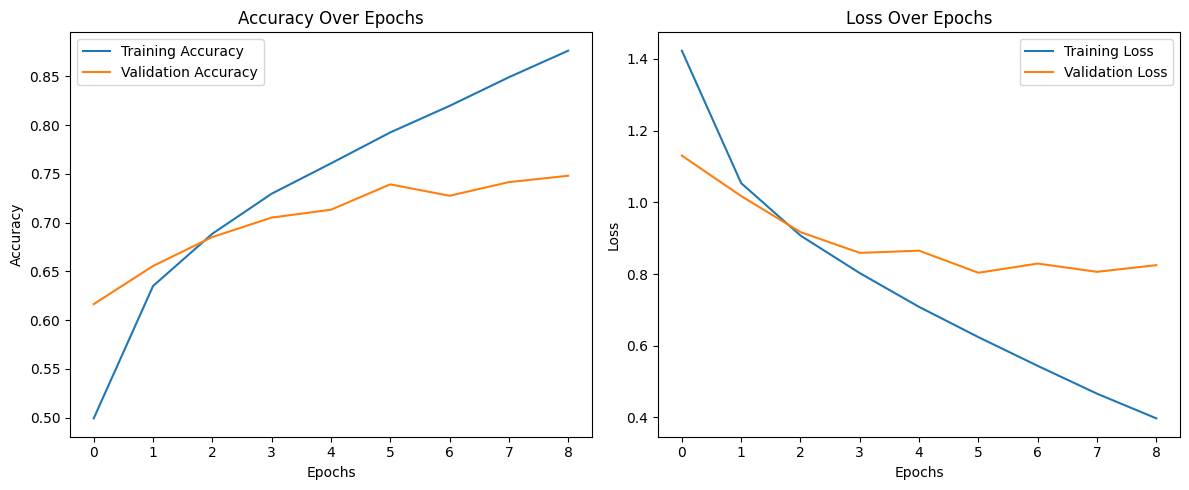

313/313 [==============================] - 14s 44ms/step - loss: 0.8381 - accuracy: 0.7410
Test loss: 0.8381251096725464
Test accuracy: 0.7409999966621399
The best initial learning rate: 0.0003848854687256898
The best learning rate schedule: constant
The best optimizer: adam
The best weight initializer: glorot_uniform
The best L2 regularization value: 0.0016431536744526529


In [35]:

best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]

best_model = build_model(best_hps)


history2 = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val),
                          callbacks=[EarlyStopping(monitor='val_loss', patience=3)])


plot_history(history2)

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")
print(f"The best initial learning rate: {best_hps.get('initial_learning_rate')}")
print(f"The best learning rate schedule: {best_hps.get('learning_rate_schedule')}")
print(f"The best optimizer: {best_hps.get('optimizer')}")
print(f"The best weight initializer: {best_hps.get('weight_initializer')}")
print(f"The best L2 regularization value: {best_hps.get('l2_regularization')}")


In [37]:
data = []
for trial in tuner2.oracle.get_best_trials(num_trials=-1):
    hp = trial.hyperparameters
    data.append({
        'learning_rate_schedule': hp.get('learning_rate_schedule'),
        'weight_initializer': hp.get('weight_initializer'),
        'val_accuracy': trial.score
    })

hp_df = pd.DataFrame(data)



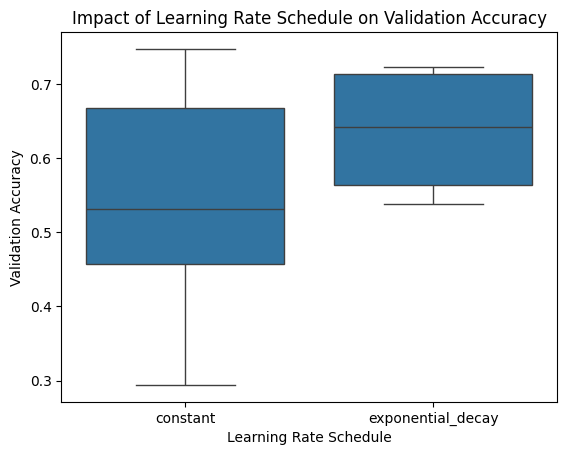

In [38]:

import seaborn as sns

# Visualizing learning rate schedule impact
sns.boxplot(x='learning_rate_schedule', y='val_accuracy', data=hp_df)
plt.title('Impact of Learning Rate Schedule on Validation Accuracy')
plt.xlabel('Learning Rate Schedule')
plt.ylabel('Validation Accuracy')
plt.show()


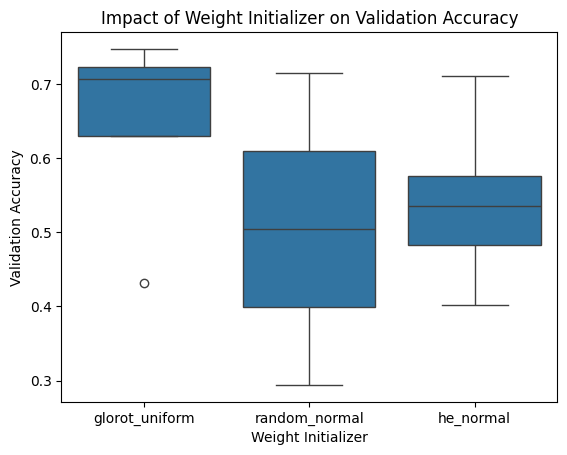

In [39]:
# Visualizing weight initializer impact
sns.boxplot(x='weight_initializer', y='val_accuracy', data=hp_df)
plt.title('Impact of Weight Initializer on Validation Accuracy')
plt.xlabel('Weight Initializer')
plt.ylabel('Validation Accuracy')
plt.show()
